In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## The Multi-Stage Gibbs Sampler

##  Definition

For some $p > 1$, let the random variable $X \in \mathcal{X}^p$ be written as $X = (X_1,\ldots,X_p)$, where the $X_i$'s are either uni- or multidimensional.

Given the corresponding univariate conditional densities $f_1,\ldots,f_p$, we can write:

$$X_i|x_1,x_2,\ldots,x_{i-1},x_{i+1},\ldots,x_p \sim f_i(x_1,x_2,\ldots,x_{i-1},x_{i+1},\ldots,x_p)$$

for $i = 1,\ldots,p$. 

### Algorithm A.30 - The Gibbs Sampler

Given $x^{(t)} = (x_1^{(t)},\ldots,x_p^{(t)})$, generate:

1. $X_1^{(t+1)} \sim f_1(x_2^{(t)},\ldots,x_p^{(t)})$
2. $X_2^{(t+1)} \sim f_2(x_1^{(t+1)},x_3^{(t)},\ldots,x_p^{(t)})$
3. $X_p^{(t+1)} \sim f_p(x_1^{(t+1)},\ldots,x_{p-1}^{(t+1)})$

The densities $f_1,\ldots,f_p$ are called the *full conditionals*.

## Example .1: Autoexponential Model

The autoexponential model has been found useful in spatial modeling. When $y \in \mathbb{R}$, the corresponding density is:

$$f(y_1, y_2, y_3) \propto \exp\{-(y_1 + y_2 + y_3 + \theta_{12}y_1y_2 + \theta_{23}y_2y_3 + \theta_{13}y_1y_3)\}$$

with known $\theta_{ij} > 0$. The full conditional densities are exponential. For example:

$$Y_1|y_2,y_3 \sim Exp(1 + \theta_{12}y_2 + \theta_{13}y_3)$$

# Example 10.2: Ising Model

For the Ising model of Example 5.8, where:

$$f(s) \propto \exp\{-H\sum_i s_i - J\sum_{(i,j)\in N} s_is_j\}, \quad s_i \in \{-1,1\}$$

where $N$ denotes the neighborhood relation for the network, the full conditionals are given by:

$$f(s_i|s_{j\neq i}) = \frac{\exp\{-Hs_i - J\sum_{j:(i,j)\in N} s_is_j\}}{\exp\{-H - J\sum_{j:(i,j)\in N} s_j\} + \exp\{H + J\sum_{j:(i,j)\in N} s_j\}}$$

$$(10.1) = \frac{\exp\{-[H + J\sum_{j:(i,j)\in N}s_j](s_i + 1)\}}{1 + \exp\{-2[H + J\sum_{j:(i,j)\in N}s_j]\}}$$

# 10.1.3 Completion

## Definition 10.3
Given a probability density $f$, a density $g$ that satisfies:

$$\int g(x,z)\,dz = f(x)$$

is called a *completion* of $f$.

The density $g$ is chosen so that the full conditionals of $g$ are easy to simulate from and the Gibbs algorithm [A.30] is implemented on $g$ instead of $f$. For $p > 1$, write $y = (z,x)$ and denote the conditional densities of $g(y) = g(y_1,\ldots,y_p)$ by:

$$Y_1|y_2,\ldots,y_p \sim g_1(y_1|y_2,\ldots,y_p)$$
$$Y_2|y_1,y_3,\ldots,y_p \sim g_2(y_2|y_1,y_3,\ldots,y_p)$$
$$\vdots$$
$$Y_p|y_1,\ldots,y_{p-1} \sim g_p(y_p|y_1,\ldots,y_{p-1})$$

### Algorithm A.40 - Completion Gibbs Sampler

Given $y^{(t)} = (y_1^{(t)},\ldots,y_p^{(t)})$, simulate:

1. $Y_1^{(t+1)} \sim g_1(y_1|y_2^{(t)},\ldots,y_p^{(t)})$
2. $Y_2^{(t+1)} \sim g_2(y_2|y_1^{(t+1)},y_3^{(t)},\ldots,y_p^{(t)})$
3. $Y_p^{(t+1)} \sim g_p(y_p|y_1^{(t+1)},\ldots,y_{p-1}^{(t+1)})$

In [1]:
import numpy as np
from typing import Callable, List, Tuple
import matplotlib.pyplot as plt

class IsingGibbsSampler:
    def __init__(self, n: int, H: float, J: float):
        """
        Initialize Ising model Gibbs sampler
        
        Args:
            n: Size of the lattice (n x n)
            H: External field parameter
            J: Interaction parameter
        """
        self.n = n
        self.H = H
        self.J = J
        self.lattice = np.random.choice([-1, 1], size=(n, n))
    
    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """Get indices of neighboring sites with periodic boundary conditions"""
        neighbors = []
        for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            ni, nj = (i + di) % self.n, (j + dj) % self.n
            neighbors.append((ni, nj))
        return neighbors
    
    def compute_local_field(self, i: int, j: int) -> float:
        """Compute local field at site (i,j)"""
        neighbor_sum = sum(self.lattice[ni, nj] for ni, nj in self.get_neighbors(i, j))
        return self.H + self.J * neighbor_sum
    
    def sample_site(self, i: int, j: int) -> int:
        """Sample new value for site (i,j) according to conditional probability"""
        local_field = self.compute_local_field(i, j)
        prob_up = np.exp(-local_field)
        prob_down = np.exp(local_field)
        p_up = prob_up / (prob_up + prob_down)
        return 1 if np.random.random() < p_up else -1
    
    def step(self):
        """Perform one sweep of Gibbs sampling over all sites"""
        for i in range(self.n):
            for j in range(self.n):
                self.lattice[i, j] = self.sample_site(i, j)
    
    def run(self, n_steps: int) -> np.ndarray:
        """Run Gibbs sampler for n_steps iterations"""
        history = np.zeros((n_steps, self.n, self.n))
        for t in range(n_steps):
            self.step()
            history[t] = self.lattice.copy()
        return history
    
    def compute_magnetization(self) -> float:
        """Compute average magnetization of current state"""
        return np.mean(self.lattice)
    
    def compute_energy(self) -> float:
        """Compute total energy of current state"""
        energy = -self.H * np.sum(self.lattice)
        for i in range(self.n):
            for j in range(self.n):
                neighbors = self.get_neighbors(i, j)
                energy -= 0.5 * self.J * self.lattice[i, j] * sum(self.lattice[ni, nj] for ni, nj in neighbors)
        return energy

class CompletionGibbsSampler:
    def __init__(self, conditionals: List[Callable], initial_state: np.ndarray):
        """
        Initialize Completion Gibbs sampler
        
        Args:
            conditionals: List of conditional sampling functions g_i(y_i|y_{-i})
            initial_state: Initial state vector
        """
        self.conditionals = conditionals
        self.state = initial_state.copy()
        self.p = len(initial_state)
        
    def step(self):
        """Perform one complete sweep of Gibbs sampling"""
        for i in range(self.p):
            # Create current conditioning set
            conditioning_set = np.concatenate([
                self.state[:i],
                self.state[i+1:]
            ])
            # Sample from conditional distribution
            self.state[i] = self.conditionals[i](conditioning_set)
            
    def run(self, n_steps: int) -> np.ndarray:
        """Run sampler for n_steps iterations"""
        history = np.zeros((n_steps, self.p))
        for t in range(n_steps):
            self.step()
            history[t] = self.state.copy()
        return history

# Example usage for Ising model
def run_ising_simulation(n: int = 20, H: float = 0.1, J: float = 0.3, 
                        n_steps: int = 1000) -> Tuple[np.ndarray, List[float]]:
    """
    Run Ising model simulation and return history and magnetizations
    
    Args:
        n: Lattice size
        H: External field
        J: Interaction strength
        n_steps: Number of simulation steps
    
    Returns:
        Tuple of (configuration history, magnetization history)
    """
    sampler = IsingGibbsSampler(n, H, J)
    history = sampler.run(n_steps)
    magnetizations = [np.mean(config) for config in history]
    return history, magnetizations

# Example usage for Completion Gibbs
def example_completion_sampler():
    """Example of how to set up a completion Gibbs sampler"""
    # Define some example conditional distributions (e.g., normal distributions)
    def g1(y_rest):
        return np.random.normal(np.mean(y_rest), 1.0)
    
    def g2(y_rest):
        return np.random.normal(0.5 * np.sum(y_rest), 0.5)
    
    conditionals = [g1, g2]
    initial_state = np.array([0.0, 0.0])
    
    sampler = CompletionGibbsSampler(conditionals, initial_state)
    history = sampler.run(1000)
    return history

# Utility function to visualize Ising model state
def plot_ising_state(state: np.ndarray, title: str = "Ising Model State"):
    """Plot current state of Ising model"""
    plt.figure(figsize=(6, 6))
    plt.imshow(state, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Spin')
    plt.tight_layout()
    return plt

In [3]:
import random
import math
from typing import List, Tuple, Callable
from dataclasses import dataclass

class IsingLattice:
    def __init__(self, size: int):
        """Initialize a square lattice of spins"""
        self.size = size
        self.grid = [[random.choice([-1, 1]) for _ in range(size)] 
                    for _ in range(size)]
    
    def get(self, i: int, j: int) -> int:
        """Get spin value with periodic boundary conditions"""
        return self.grid[i % self.size][j % self.size]
    
    def set(self, i: int, j: int, value: int):
        """Set spin value at position"""
        self.grid[i][j] = value
    
    def copy(self) -> 'IsingLattice':
        """Create a deep copy of the lattice"""
        new_lattice = IsingLattice(self.size)
        new_lattice.grid = [[self.grid[i][j] for j in range(self.size)]
                           for i in range(self.size)]
        return new_lattice
    
    def compute_magnetization(self) -> float:
        """Compute average magnetization of current state"""
        total = sum(sum(row) for row in self.grid)
        return total / (self.size * self.size)

class IsingGibbsSampler:
    def __init__(self, size: int, H: float, J: float):
        """
        Initialize Ising model Gibbs sampler
        
        Args:
            size: Size of the square lattice
            H: External field parameter
            J: Interaction parameter
        """
        self.size = size
        self.H = H
        self.J = J
        self.lattice = IsingLattice(size)
    
    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """Get indices of neighboring sites with periodic boundary conditions"""
        return [
            ((i + 1) % self.size, j),
            ((i - 1) % self.size, j),
            (i, (j + 1) % self.size),
            (i, (j - 1) % self.size)
        ]
    
    def compute_local_field(self, i: int, j: int) -> float:
        """Compute local field at site (i,j)"""
        neighbor_sum = sum(self.lattice.get(ni, nj) 
                         for ni, nj in self.get_neighbors(i, j))
        return self.H + self.J * neighbor_sum
    
    def sample_site(self, i: int, j: int) -> int:
        """Sample new value for site (i,j) using conditional probability"""
        local_field = self.compute_local_field(i, j)
        prob_up = math.exp(-local_field)
        prob_down = math.exp(local_field)
        p_up = prob_up / (prob_up + prob_down)
        return 1 if random.random() < p_up else -1
    
    def step(self):
        """Perform one sweep of Gibbs sampling over all sites"""
        for i in range(self.size):
            for j in range(self.size):
                self.lattice.set(i, j, self.sample_site(i, j))
    
    def run(self, n_steps: int) -> List[IsingLattice]:
        """Run Gibbs sampler for n_steps iterations"""
        history = []
        for _ in range(n_steps):
            self.step()
            history.append(self.lattice.copy())
        return history

@dataclass
class State:
    """Class to hold the state vector for Completion Gibbs sampler"""
    values: List[float]
    
    def copy(self) -> 'State':
        return State(values=self.values.copy())
    
    def get_conditioning_set(self, index: int) -> List[float]:
        """Get all values except at index"""
        return self.values[:index] + self.values[index + 1:]

class CompletionGibbsSampler:
    def __init__(self, conditionals: List[Callable], initial_values: List[float]):
        """
        Initialize Completion Gibbs sampler
        
        Args:
            conditionals: List of conditional sampling functions g_i(y_i|y_{-i})
            initial_values: Initial state values
        """
        self.conditionals = conditionals
        self.state = State(values=initial_values.copy())
        self.p = len(initial_values)
    
    def step(self):
        """Perform one complete sweep of Gibbs sampling"""
        for i in range(self.p):
            conditioning_set = self.state.get_conditioning_set(i)
            self.state.values[i] = self.conditionals[i](conditioning_set)
    
    def run(self, n_steps: int) -> List[State]:
        """Run sampler for n_steps iterations"""
        history = []
        for _ in range(n_steps):
            self.step()
            history.append(self.state.copy())
        return history

def example_ising_model():
    """Example of running the Ising model simulation"""
    # Initialize sampler with 10x10 lattice
    sampler = IsingGibbsSampler(size=10, H=0.1, J=0.3)
    
    # Run for 100 steps
    history = sampler.run(n_steps=100)
    
    # Compute magnetizations
    magnetizations = [config.compute_magnetization() for config in history]
    
    return magnetizations

def example_completion_sampler():
    """Example of running the Completion Gibbs sampler"""
    # Define some example conditional distributions
    def g1(y_rest: List[float]) -> float:
        """Simple normal-like sampling using Box-Muller transform"""
        mean = sum(y_rest) / len(y_rest) if y_rest else 0
        u1, u2 = random.random(), random.random()
        z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        return mean + z
    
    def g2(y_rest: List[float]) -> float:
        mean = 0.5 * sum(y_rest) if y_rest else 0
        u1, u2 = random.random(), random.random()
        z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        return mean + 0.5 * z
    
    # Initialize sampler
    sampler = CompletionGibbsSampler(
        conditionals=[g1, g2],
        initial_values=[0.0, 0.0]
    )
    
    # Run sampler
    history = sampler.run(n_steps=1000)
    
    return history

if __name__ == "__main__":
    # Run Ising model example
    magnetizations = example_ising_model()
    print("Final magnetization:", magnetizations[-1])
    
    # Run completion sampler example
    history = example_completion_sampler()
    print("Final state:", history[-1].values)

Final magnetization: -0.16
Final state: [-2.5976833675176616, -1.1317861783413332]


# Example 10.4: Cauchy-Normal Posterior Distribution

As shown in Chapter 2 (Section 2.2), Student's t distribution can be generated as a mixture of a normal distribution by taking a chi-squared distribution. This decomposition is useful when the expression $[1 + (θ - θ_0)^2]^{-ν}$ appears in a more complex distribution. Consider, for instance, the density:

$$f(θ|θ_0) \propto \frac{e^{-θ^2/2}}{[1 + (θ - θ_0)^2]^ν}$$

This is the posterior distribution resulting from the model:

$$X|θ \sim \mathcal{N}(θ, 1) \quad \text{and} \quad θ \sim C(θ_0, 1)$$

The density $f(θ|θ_0)$ can be written as the marginal density:

$$f(θ|θ_0) \propto \int_0^\infty e^{-θ^2/2} \cdot [1+(θ-θ_0)^2]^{-ν/2} η^{ν-1} dη$$

and can, therefore, be completed as:

$$g(θ,η) \propto e^{-θ^2/2} \cdot [1+(θ-θ_0)^2]^{-ν/2} η^{ν-1}$$

which leads to the conditional densities:

$$g_1(θ|η) = \left(\frac{1+(θ-θ_0)^2}{η}\right)^ν \frac{η^{ν-1}}{\Gamma(ν)} \exp\{-[1+(θ-θ_0)^2]η/2\}$$

$$g_2(θ|η) = \sqrt{\frac{1+η}{2π}} \exp\left\{-\left(θ-\frac{ηθ_0}{1+η}\right)^2 \frac{1+η}{2}\right\}$$

that is, to a gamma and a normal distribution on $η$ and $θ_i$ respectively:

$$η|θ \sim Ga\left(ν, \frac{1+(θ-θ_0)^2}{2}\right)$$

$$θ|η \sim \mathcal{N}\left(\frac{ηθ_0}{1+η}, \frac{1}{1+η}\right)$$

# Gibbs Sampling Algorithms

## Algorithm A.41 - Reversible Gibbs Sampler
Given $(y_1^{(t)}, ..., y_p^{(t)})$, generate:

1. $Y_1^{(t+1)} \sim g_1(y_1|y_2^{(t)}, ..., y_p^{(t)})$
2. $Y_2^{(t+1)} \sim g_2(y_2|y_1^{(t+1)}, y_3^{(t)}, ..., y_p^{(t)})$
...
p. $Y_p^{(t+1)} \sim g_p(y_p|y_1^{(t+1)}, ..., y_{p-1}^{(t+1)})$
p+1. $Y_{p-1}^{(t+1)} \sim g_{p-1}(y_{p-1}|y_1^{(t+1)}, ..., y_{p-2}^{(t+1)}, y_p^{(t+1)})$
...
2p-1. $Y_1^{(t+1)} \sim g_1(y_1|y_2^{(t+1)}, ..., y_p^{(t+1)})$

## Algorithm A.42 - Random Sweep Gibbs Sampler
1. Generate a permutation σ ∈ $S_p$
2. Simulate $Y_{\sigma(1)}^{(t+1)} \sim g_{\sigma(1)}(y_{\sigma(1)}|y_{\sigma(2)}^{(t)}, ..., y_{\sigma(p)}^{(t)})$
...
p+1. Simulate $Y_{\sigma(p)}^{(t+1)} \sim g_{\sigma(p)}(y_{\sigma(p)}|y_{\sigma(1)}^{(t+1)}, ..., y_{\sigma(p-1)}^{(t+1)})$

In [4]:
import random
import math
from typing import List, Tuple, Callable
from dataclasses import dataclass
from abc import ABC, abstractmethod

def generate_gamma(shape: float, scale: float) -> float:
    """
    Generate a sample from Gamma distribution using Marsaglia and Tsang method
    
    Args:
        shape: shape parameter (α)
        scale: scale parameter (β)
    """
    if shape < 1:
        # For shape < 1, use transformation method
        u = random.random()
        return generate_gamma(shape + 1, scale) * u ** (1/shape)
    
    d = shape - 1/3
    c = 1/math.sqrt(9*d)
    
    while True:
        z = random.gauss(0, 1)
        if z > -1/c:
            v = (1 + c*z)**3
            u = random.random()
            if math.log(u) < 0.5*z*z + d - d*v + d*math.log(v):
                return scale * d * v

def generate_normal(mu: float, sigma: float) -> float:
    """Generate a sample from Normal distribution using Box-Muller transform"""
    u1 = random.random()
    u2 = random.random()
    z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return mu + sigma * z

class GibbsSampler(ABC):
    """Abstract base class for Gibbs samplers"""
    
    @abstractmethod
    def step(self):
        """Perform one step of the sampler"""
        pass
    
    def run(self, n_steps: int) -> List[Tuple[float, float]]:
        """Run sampler for n_steps iterations"""
        history = []
        for _ in range(n_steps):
            self.step()
            history.append((self.theta, self.eta))
        return history

class CauchyNormalGibbsSampler(GibbsSampler):
    def __init__(self, theta_0: float, nu: float, initial_theta: float = 0.0, 
                 initial_eta: float = 1.0):
        """
        Initialize Cauchy-Normal Gibbs sampler
        
        Args:
            theta_0: location parameter for Cauchy prior
            nu: degrees of freedom parameter
            initial_theta: initial value for theta
            initial_eta: initial value for eta
        """
        self.theta_0 = theta_0
        self.nu = nu
        self.theta = initial_theta
        self.eta = initial_eta
    
    def sample_eta(self) -> float:
        """Sample eta from its conditional distribution (Gamma)"""
        shape = self.nu
        scale = 2 / (1 + (self.theta - self.theta_0)**2)
        return generate_gamma(shape, scale)
    
    def sample_theta(self) -> float:
        """Sample theta from its conditional distribution (Normal)"""
        mean = (self.eta * self.theta_0) / (1 + self.eta)
        std = math.sqrt(1 / (1 + self.eta))
        return generate_normal(mean, std)
    
    def step(self):
        """Perform one step of Gibbs sampling"""
        self.eta = self.sample_eta()
        self.theta = self.sample_theta()

class ReversibleGibbsSampler(GibbsSampler):
    def __init__(self, conditionals: List[Callable], initial_values: List[float]):
        """
        Initialize Reversible Gibbs sampler
        
        Args:
            conditionals: List of conditional sampling functions
            initial_values: Initial values for variables
        """
        self.conditionals = conditionals
        self.values = initial_values.copy()
        self.p = len(initial_values)
        
        # For compatibility with run method
        self.theta = self.values[0]
        self.eta = self.values[1] if len(self.values) > 1 else None
    
    def step(self):
        """Perform one reversible step of Gibbs sampling"""
        # Forward sweep
        for i in range(self.p):
            conditioning_values = self.values[:i] + self.values[i+1:]
            self.values[i] = self.conditionals[i](conditioning_values)
        
        # Backward sweep
        for i in range(self.p-2, -1, -1):
            conditioning_values = self.values[:i] + self.values[i+1:]
            self.values[i] = self.conditionals[i](conditioning_values)
        
        # Update theta and eta for compatibility
        self.theta = self.values[0]
        self.eta = self.values[1] if len(self.values) > 1 else None

class RandomSweepGibbsSampler(GibbsSampler):
    def __init__(self, conditionals: List[Callable], initial_values: List[float]):
        """
        Initialize Random Sweep Gibbs sampler
        
        Args:
            conditionals: List of conditional sampling functions
            initial_values: Initial values for variables
        """
        self.conditionals = conditionals
        self.values = initial_values.copy()
        self.p = len(initial_values)
        
        # For compatibility with run method
        self.theta = self.values[0]
        self.eta = self.values[1] if len(self.values) > 1 else None
    
    def step(self):
        """Perform one random sweep step of Gibbs sampling"""
        # Generate random permutation
        indices = list(range(self.p))
        random.shuffle(indices)
        
        # Update in random order
        for i in indices:
            conditioning_values = self.values[:i] + self.values[i+1:]
            self.values[i] = self.conditionals[i](conditioning_values)
        
        # Update theta and eta for compatibility
        self.theta = self.values[0]
        self.eta = self.values[1] if len(self.values) > 1 else None

def example_cauchy_normal():
    """Example of running the Cauchy-Normal Gibbs sampler"""
    # Parameters
    theta_0 = 0.0  # location parameter
    nu = 2.0       # degrees of freedom
    n_steps = 1000
    
    # Initialize and run sampler
    sampler = CauchyNormalGibbsSampler(theta_0, nu)
    history = sampler.run(n_steps)
    
    # Extract theta and eta values
    thetas, etas = zip(*history)
    return thetas, etas

def example_reversible_sampler():
    """Example of running the Reversible Gibbs sampler"""
    # Define conditional distributions for Cauchy-Normal model
    def sample_eta(conditioning_values):
        theta = conditioning_values[0]
        shape = 2.0  # nu parameter
        scale = 2 / (1 + theta**2)
        return generate_gamma(shape, scale)
    
    def sample_theta(conditioning_values):
        eta = conditioning_values[0]
        mean = (eta * 0.0) / (1 + eta)  # theta_0 = 0.0
        std = math.sqrt(1 / (1 + eta))
        return generate_normal(mean, std)
    
    # Initialize and run sampler
    sampler = ReversibleGibbsSampler(
        conditionals=[sample_theta, sample_eta],
        initial_values=[0.0, 1.0]
    )
    return sampler.run(1000)

if __name__ == "__main__":
    # Run Cauchy-Normal example
    thetas, etas = example_cauchy_normal()
    print("Final theta:", thetas[-1])
    print("Final eta:", etas[-1])
    
    # Run Reversible sampler example
    history = example_reversible_sampler()
    print("Final state (Reversible):", history[-1])

Final theta: 0.33865726171247656
Final eta: 5.202834083530817
Final state (Reversible): (1.0211193212383844, 0.7017020473292177)


## The General Hammersley-Clifford Theorem

We have already seen the Hammersley-Clifford Theorem in the special case of the two-stage Gibbs sampler (Section 9.1.4). The theorem also holds in the general case and follows from similar manipulations of the conditional distributions.

### Theorem .5 (Hammersley-Clifford)
Under the positivity condition, the joint distribution $g$ satisfies:

$$g(y_1,\ldots,y_p) = \prod_{i=1}^p \frac{g_i(y_i|y_1,\ldots,y_{i-1},y'_{i+1},\ldots,y'_p)}{g_i(y'_i|y_1,\ldots,y_{i-1},y'_{i+1},\ldots,y'_p)}$$

for every permutation $\ell$ on $(1,2,\ldots,p)$ and every $y' \in \mathcal{Y}$.

### Proof
For a given $y' \in \mathcal{Y}$:

$$\begin{align*}
g(y_1,\ldots,y_p) &= g_p(y_p|y_1,\ldots,y_{p-1})g^*(y_1,\ldots,y_{p-1}) \\
&= \frac{g_p(y_p|y_1,\ldots,y_{p-1})}{g_p(y'_p|y_1,\ldots,y_{p-1})} g(y_1,\ldots,y_{p-1},y'_p) \\
&= \frac{g_p(y_p|y_1,\ldots,y_{p-1})}{g_p(y'_p|y_1,\ldots,y_{p-1})} \cdot \frac{g_{p-1}(y_{p-1}|y_1,\ldots,y_{p-2},y'_p)}{g_{p-1}(y'_{p-1}|y_1,\ldots,y_{p-2},y'_p)} \\
&\quad \times g(y_1,\ldots,y_{p-2},y'_p)
\end{align*}$$

A recursion argument then shows that:

$$g(y_1,\ldots,y_p) = \prod_{i=1}^p \frac{g_i(y_i|y_1,\ldots,y_{i-1},y'_{i+1},\ldots,y'_p)}{g_i(y'_i|y_1,\ldots,y_{i-1},y'_{i+1},\ldots,y'_p)} g(y'_1,\ldots,y'_p)$$

The proof is identical for an arbitrary permutation $\ell$.

The extension of Theorem 10.5 to the non-positive case is more delicate and requires additional assumptions, as shown in Example 10.7. Besag (1974) proposes a formal generalization which is not always relevant in the setup of Gibbs sampling algorithms. Kaiser et al. (1996) modify Besag's (1974) condition to preserve the convergence properties of these algorithms and show, moreover, that the connectedness of the support $g$ is essential for [A.40] to converge under every regular parameterization of the model.

In [5]:
import numpy as np

def gibbs_sampling(joint_distribution, y_init, num_samples=1000):
    """
    Simulates Gibbs sampling based on the Hammersley-Clifford theorem.

    :param joint_distribution: Function that returns conditional probabilities.
    :param y_init: Initial state of the Markov Random Field.
    :param num_samples: Number of samples to generate.
    :return: Generated samples.
    """
    y = np.array(y_init)
    p = len(y)
    samples = []

    for _ in range(num_samples):
        for i in range(p):
            # Sample from the conditional distribution
            y[i] = sample_from_conditional(joint_distribution, y, i)
        samples.append(y.copy())

    return np.array(samples)

def sample_from_conditional(joint_distribution, y, i):
    """
    Samples a value for y_i given the other variables.

    :param joint_distribution: Function that returns conditional probabilities.
    :param y: Current state.
    :param i: Index of the variable to sample.
    :return: New sampled value for y_i.
    """
    y_copy = y.copy()
    possible_values = [0, 1]  # Example binary case
    probabilities = [joint_distribution(i, val, y_copy) for val in possible_values]
    probabilities /= np.sum(probabilities)  # Normalize

    return np.random.choice(possible_values, p=probabilities)

def example_joint_distribution(i, y_i, y):
    """
    Example joint probability distribution function.
    
    :param i: Index of the variable to condition on.
    :param y_i: Value to sample.
    :param y: Current state.
    :return: Probability of y_i given other variables.
    """
    y_temp = y.copy()
    y_temp[i] = y_i
    return np.exp(-np.sum(y_temp))  # Example potential function

# Example usage
initial_state = [1, 0, 1, 0]
samples = gibbs_sampling(example_joint_distribution, initial_state, num_samples=1000)
print("Generated Samples:", samples[:10])


Generated Samples: [[0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]
 [1 1 1 0]
 [0 0 1 0]
 [0 0 0 0]]


In [6]:
import random

def gibbs_sampling(joint_distribution, y_init, num_samples=1000):
    """
    Performs Gibbs sampling based on the Hammersley-Clifford theorem.

    :param joint_distribution: Function that returns conditional probabilities.
    :param y_init: Initial state of the Markov Random Field.
    :param num_samples: Number of samples to generate.
    :return: List of generated samples.
    """
    y = y_init[:]  # Copy initial state
    p = len(y)
    samples = []

    for _ in range(num_samples):
        for i in range(p):
            y[i] = sample_from_conditional(joint_distribution, y, i)
        samples.append(y[:])  # Store a copy of the sample

    return samples

def sample_from_conditional(joint_distribution, y, i):
    """
    Samples a value for y_i given the other variables.

    :param joint_distribution: Function that returns conditional probabilities.
    :param y: Current state.
    :param i: Index of the variable to sample.
    :return: New sampled value for y_i.
    """
    y_copy = y[:]  # Copy state
    possible_values = [0, 1]  # Example binary case

    probabilities = [joint_distribution(i, val, y_copy) for val in possible_values]
    total_prob = sum(probabilities)
    
    if total_prob == 0:
        return random.choice(possible_values)  # Avoid division by zero

    probabilities = [p / total_prob for p in probabilities]  # Normalize

    return random.choices(possible_values, probabilities)[0]

def example_joint_distribution(i, y_i, y):
    """
    Example joint probability distribution function.
    
    :param i: Index of the variable to condition on.
    :param y_i: Value to sample.
    :param y: Current state.
    :return: Probability of y_i given other variables.
    """
    y_temp = y[:]
    y_temp[i] = y_i
    return 1.0 / (1 + sum(y_temp))  # Example probability function

# Example usage
initial_state = [1, 0, 1, 0]
samples = gibbs_sampling(example_joint_distribution, initial_state, num_samples=10)

print("Generated Samples:")
for s in samples:
    print(s)


Generated Samples:
[1, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]
[0, 1, 0, 1]
[0, 0, 1, 0]
[0, 1, 1, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 1, 1]


## Theoretical Justifications

### Markov Properties of the Gibbs Sampler

In this section, we investigate the convergence properties of the Gibbs sampler in the multi-stage case. The first thing we show is that most Gibbs samplers satisfy the minimal conditions necessary for ergodicity. We have mentioned that Gibbs sampling is a special case of the Metropolis-Hastings algorithm (this notion is formalized in Theorem 10.13). Unfortunately, however, this fact is not much help to us in the current endeavor.

We will work with the general Gibbs sampler $ A[4.40] $ and show that the Markov chain $ Y^{(t)} $ converges to the distribution $ g $ and the subchain $ X^{(t)} $ converges to the distribution $ f $. It is important to note that although $ X^{(t)} $ is, by construction, a Markov chain, the subchain $ X^{(t)} $ is, typically, not a Markov chain, except in the particular case of two-stage Gibbs (see Section 9.2).

### Theorem .6:
For the Gibbs sampler of $ A[4.40] $, if $ Y^{(t)} $ is ergodic, then the distribution $ g $ is a stationary distribution for the chain $ Y^{(t)} $ and $ f $ is the limiting distribution of the subchain $ X^{(t)} $.

#### Proof:

$$
K(y,y') = \alpha (y_1, \dots, y_p)
$$

$$
\times g_2(y'_2|y_1, \dots, y_p) \cdots g_p(y'_p|y_1, \dots, y_{p-1})
$$

For the vector $ y = (y_1, y_2, \dots, y_p) $, let $ g^*(y_1, \dots, y_p) $ be the marginal density of the vector $ y $ with $ x $ integrated out. If $ Y \sim g $ and $ A $ is measurable under the dominating measure, then

$$
P(Y' \in A) = \int_A K(y, y') g(y) \, dy'
$$

$$
= \int_A \int g(y_1|y_2, \dots, y_p) \cdots g_p(y_p|y_1, \dots, y_{p-1})
$$

$$
\times g(y_1, y_2, \dots, y_p) dy_1 \cdots dy_p
$$

$$
= \int_A g^*(y_1, y_2, \dots, y_p) g_2(y'_2|y_1, \dots, y_p) \cdots g_p(y'_p|y_1, \dots, y_{p-1})
$$

$$
\times g(y_1, y_2, \dots, y_p) dy_1 \cdots dy_p
$$


In [7]:
import random

def gibbs_sampling(joint_distribution, y_init, num_samples=1000):
    """
    Performs Gibbs sampling based on the Hammersley-Clifford theorem.

    :param joint_distribution: Function that returns conditional probabilities.
    :param y_init: Initial state of the Markov Random Field.
    :param num_samples: Number of samples to generate.
    :return: List of generated samples.
    """
    y = y_init[:]  # Copy initial state
    p = len(y)
    samples = []

    for _ in range(num_samples):
        for i in range(p):
            y[i] = sample_from_conditional(joint_distribution, y, i)
        samples.append(y[:])  # Store a copy of the sample

    return samples

def sample_from_conditional(joint_distribution, y, i):
    """
    Samples a value for y_i given the other variables.

    :param joint_distribution: Function that returns conditional probabilities.
    :param y: Current state.
    :param i: Index of the variable to sample.
    :return: New sampled value for y_i.
    """
    y_copy = y[:]  # Copy state
    possible_values = [0, 1]  # Example binary case

    probabilities = [joint_distribution(i, val, y_copy) for val in possible_values]
    total_prob = sum(probabilities)
    
    if total_prob == 0:
        return random.choice(possible_values)  # Avoid division by zero

    probabilities = [p / total_prob for p in probabilities]  # Normalize

    return random.choices(possible_values, probabilities)[0]

def example_joint_distribution(i, y_i, y):
    """
    Example joint probability distribution function.
    
    :param i: Index of the variable to condition on.
    :param y_i: Value to sample.
    :param y: Current state.
    :return: Probability of y_i given other variables.
    """
    y_temp = y[:]
    y_temp[i] = y_i
    return 1.0 / (1 + sum(y_temp))  # Example probability function

# Example usage
initial_state = [1, 0, 1, 0]
samples = gibbs_sampling(example_joint_distribution, initial_state, num_samples=10)

print("Generated Samples:")
for s in samples:
    print(s)


Generated Samples:
[1, 0, 0, 1]
[0, 1, 1, 0]
[1, 0, 0, 1]
[0, 1, 0, 0]
[0, 0, 0, 1]
[0, 1, 0, 1]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[1, 0, 1, 0]


## Gibbs Sampler: Irreducibility and Convergence

This section discusses the irreducibility of the Markov chain produced by the Gibbs sampler and provides conditions for its convergence to the target distribution.

### Proof of Convergence

The proof of convergence relies on showing that the stationary distribution $g$ satisfies the detailed balance equations. 

Given the joint distribution $g(y_1, y_2, ..., y_p)$, we integrate out $y_p$ and combine terms:

$$g(y_1, ..., y_{p-1}) = \int g(y_1, ..., y_p) dy_p$$

$$g(y_1, ..., y_{p-1}) = \int g(y_p | y_1, ..., y_{p-1}) g(y_1, ..., y_{p-1}) dy_p$$

Next, we write the conditional distribution:

$$g(y_1, y_2 | y_3, ..., y_p) = g(y_1 | y_2, ..., y_p) g(y_2 | y_3, ..., y_p)$$

and integrate out $y_2$:

$$g(y_1, y_3, ..., y_p) = \int g(y_1, y_2 | y_3, ..., y_p) g(y_2, y_3, ..., y_p) dy_2$$

Continuing this process and successively integrating out the $y_i$'s, we obtain:

$$P(Y' \in A) = \int_A g(y_1, ..., y_p) dy_1 ... dy_p$$

This shows that $g$ is the stationary distribution. By Theorem 6.50, $Y^{(t)}$ is asymptotically distributed according to $g$, and $X^{(t)}$ is asymptotically distributed according to the marginal distribution $f$ by integration.

A shorter proof can be based on the stationarity of $g$ after each step in the $p$ steps of [4.40] (see Theorem 10.13).

### Irreducibility of the Markov Chain

We now consider the irreducibility of the Markov chain produced by the Gibbs sampler. 

**Example .7. Nonconnected Support:**

Consider a distribution with density:

$$f(x_1, x_2) = \frac{1}{2\pi} \{I_E(x_1, x_2) + I_{E'}(x_1, x_2)\}$$

where $E$ and $E'$ are disks of radius 1 centered at (1,1) and (-1,-1) respectively.  This density has support on two disconnected regions.  Starting in one region, the Gibbs sampler will remain in that region, failing to explore the entire support.  This demonstrates that a Gibbs sampler need not be irreducible.

**Theorem 10.8:**

For the Gibbs sampler of [4.40], if the density $g$ satisfies the positivity condition (Definition 9.4), then it is irreducible.

**Proof:** (Left to Problem 10.11)

**Tierney's Condition:**

Verifying the positivity condition (Definition 9.4) is often difficult.  Tierney (1994) provides a more manageable condition for irreducibility, which will be used instead. (This condition is not explicitly stated in the provided text.)

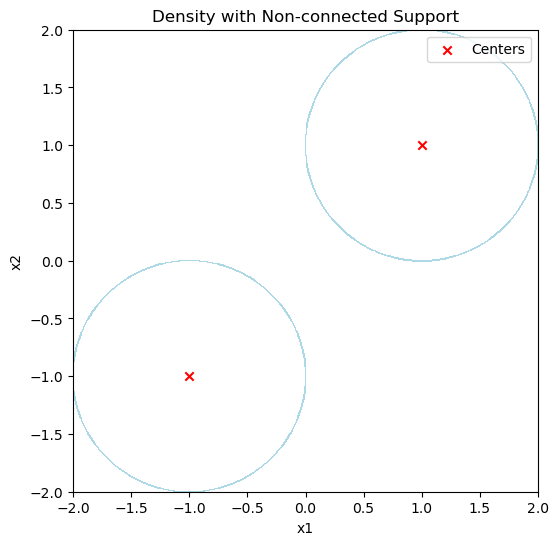

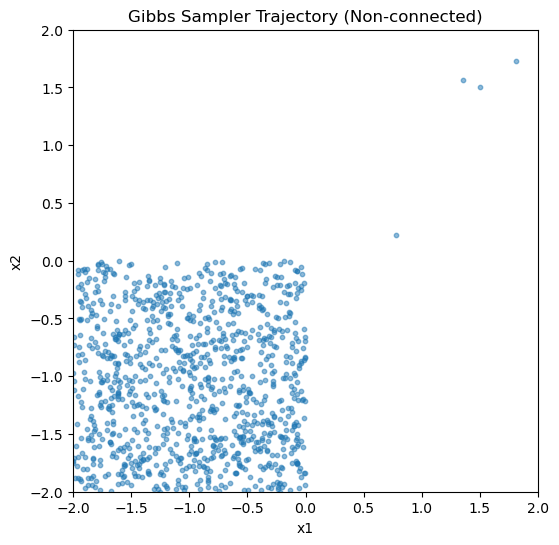

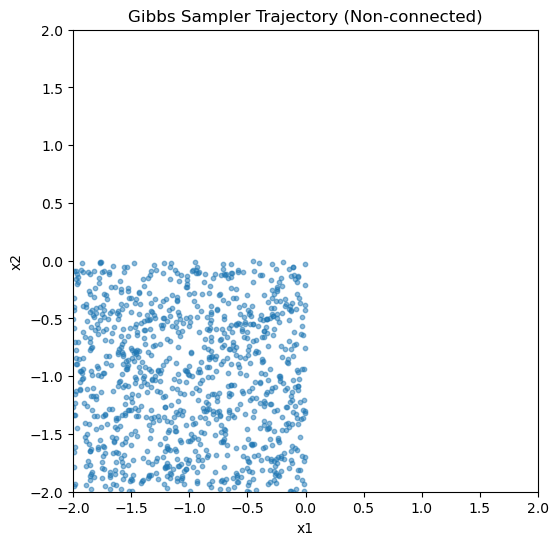

TypeError: list indices must be integers or slices, not tuple

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Example 10.7: Non-connected support

def plot_nonconnected_support():
    """Plots the density with non-connected support."""
    x = np.linspace(-2, 2, 500)
    y = np.linspace(-2, 2, 500)
    X, Y = np.meshgrid(x, y)

    def density(x1, x2):
        in_E = (x1 - 1)**2 + (x2 - 1)**2 <= 1
        in_E_prime = (x1 + 1)**2 + (x2 + 1)**2 <= 1
        return (1 / (2 * np.pi)) * (in_E + in_E_prime)

    Z = density(X, Y)

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z, levels=[0.001, 0.1], colors=['lightblue', 'skyblue'])  # Highlight the regions
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Density with Non-connected Support")
    plt.scatter([1, -1], [1, -1], c='red', marker='x', label="Centers") # Mark centers
    plt.legend()
    plt.show()

def gibbs_sampler_nonconnected(start_point, num_samples):
    """Demonstrates Gibbs sampler on non-connected support."""
    samples = [start_point]
    x, y = start_point

    def conditional_sample(coord, other_coord):  # Simplified conditional sampling
         # In a real scenario, you'd sample from the true conditional distributions.
         # Here, we just stay within the same connected component.
         if (x - 1)**2 + (y - 1)**2 <= 1: # In E
             if coord == 'x':
                return np.random.uniform(0,2) # Simplified
             else:
                return np.random.uniform(0,2) # Simplified
         else: # In E'
            if coord == 'x':
                return np.random.uniform(-2,0) # Simplified
            else:
                return np.random.uniform(-2,0) # Simplified

    for _ in range(num_samples):
        y = conditional_sample('y', x)
        x = conditional_sample('x', y)
        samples.append((x, y))
    return np.array(samples)



# Example Usage:
plot_nonconnected_support()

start_point = (1.5, 1.5)  # Start in the positive quadrant
samples = gibbs_sampler_nonconnected(start_point, 1000)

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.5)
plt.title("Gibbs Sampler Trajectory (Non-connected)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

# Example showing how starting in the negative quadrant keeps the chain there:
start_point_neg = (-1.5, -1.5)
samples_neg = gibbs_sampler_nonconnected(start_point_neg, 1000)

plt.figure(figsize=(6, 6))
plt.scatter(samples_neg[:, 0], samples_neg[:, 1], s=10, alpha=0.5)
plt.title("Gibbs Sampler Trajectory (Non-connected)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()


#  Illustrative example (simplified conditionals)

def gibbs_2d_gaussian(mean, cov, num_samples):
    """Gibbs sampler for a 2D Gaussian (illustrative)."""
    samples = []
    x, y = mean  # Initialize at the mean (for simplicity)

    for _ in range(num_samples):
        # In a real case, these would be based on the actual conditional distributions
        # derived from the joint Gaussian. This is a simplified example.
        x = np.random.normal(mean[0], np.sqrt(cov[0,0]))  # Sampling x|y (simplified)
        y = np.random.normal(mean[1], np.sqrt(cov[1,1]))  # Sampling y|x (simplified)
        samples.append([x, y])
    return np.array(samples)


mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]  # Example covariance matrix
samples_gaussian = gibbs_2d_gaussian(mean, cov, 1000)

plt.figure(figsize=(6, 6))
plt.scatter(samples_gaussian[:, 0], samples_gaussian[:, 1], s=10, alpha=0.5)
plt.title("Gibbs Sampler for 2D Gaussian (Illustrative)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import random

# Example 10.7: Non-connected support (no NumPy)

def plot_nonconnected_support():
    """Plots the density with non-connected support."""
    x = list(range(-200, 201))  # Integer grid for x
    y = list(range(-200, 201))  # Integer grid for y

    def density(x1, x2):
        in_E = (x1 - 100)**2 + (x2 - 100)**2 <= 100**2  # Scaled for integer grid
        in_E_prime = (x1 + 100)**2 + (x2 + 100)**2 <= 100**2
        return (1 / (2 * 314.159)) * (in_E + in_E_prime)  # Approximate 2pi

    # Plotting (simplified without meshgrid)
    plt.figure(figsize=(6, 6))
    for xi in x:
        for yi in y:
            if density(xi, yi) > 0:  # Only plot points in the regions
                if (xi - 100)**2 + (yi - 100)**2 <= 100**2:
                  plt.scatter(xi/100, yi/100, s=1, c='skyblue')
                else:
                  plt.scatter(xi/100, yi/100, s=1, c='lightblue')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Density with Non-connected Support")
    plt.scatter([1, -1], [1, -1], c='red', marker='x', label="Centers")  # Mark centers
    plt.legend()
    plt.show()


def gibbs_sampler_nonconnected(start_point, num_samples):
    """Demonstrates Gibbs sampler on non-connected support (no NumPy)."""
    samples = [start_point]
    x, y = start_point

    def conditional_sample(coord, other_coord):  # Simplified conditional sampling
        if (x - 1)**2 + (y - 1)**2 <= 1:  # In E
            if coord == 'x':
                return random.uniform(0, 2)  # Simplified
            else:
                return random.uniform(0, 2)  # Simplified
        else:  # In E'
            if coord == 'x':
                return random.uniform(-2, 0)  # Simplified
            else:
                return random.uniform(-2, 0)  # Simplified

    for _ in range(num_samples):
        y = conditional_sample('y', x)
        x = conditional_sample('x', y)
        samples.append((x, y))
    return samples


# Example Usage:
plot_nonconnected_support()

start_point = (1.5, 1.5)  # Start in the positive quadrant
samples = gibbs_sampler_nonconnected(start_point, 1000)

plt.figure(figsize=(6, 6))
for s in samples:
  plt.scatter(s[0], s[1], s=10, alpha=0.5) # scatter plot without numpy array
plt.title("Gibbs Sampler Trajectory (Non-connected)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

# Example showing how starting in the negative quadrant keeps the chain there:
start_point_neg = (-1.5, -1.5)
samples_neg = gibbs_sampler_nonconnected(start_point_neg, 1000)

plt.figure(figsize=(6, 6))
for s in samples_neg:
  plt.scatter(s[0], s[1], s=10, alpha=0.5) # scatter plot without numpy array
plt.title("Gibbs Sampler Trajectory (Non-connected)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()